# Braille Detection PyTorch

## 1. 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 필요 라이브러리 설치

In [ ]:
!pip install -r "/content/drive/MyDrive/PyTorch/requirements.txt"
!pip install albumentations==0.4.6

In [ ]:
import json
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 
from tqdm import tqdm

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch import nn
from torch import optim

import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data import SequentialSampler
from torch.utils.tensorboard import SummaryWriter

## 3. Data 확인 및 정리

In [ ]:
BASE_PATH = "/content/drive/MyDrive/PyTorch/AngelinaBook"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH = os.path.join(BASE_PATH, "val")
TRAIN_JSON_PATH = os.path.join(TRAIN_PATH, "json")
TRAIN_IMG_PATH = os.path.join(TRAIN_PATH, "image")
TRAIN_JSON_FILES = [os.path.join(TRAIN_JSON_PATH, f) for f in os.listdir(TRAIN_JSON_PATH)]
VAL_JSON_PATH = os.path.join(VAL_PATH, "json")
VAL_IMG_PATH = os.path.join(VAL_PATH, "image")
VAL_JSON_FILES = [os.path.join(VAL_JSON_PATH, f) for f in os.listdir(VAL_JSON_PATH)]

In [ ]:
print(TRAIN_JSON_FILES[:5])

['/content/drive/MyDrive/PyTorch/AngelinaBook/train/json/IMG_20190715_122826.labeled.json', '/content/drive/MyDrive/PyTorch/AngelinaBook/train/json/IMG_20190715_113026.labeled.json', '/content/drive/MyDrive/PyTorch/AngelinaBook/train/json/IMG_20190715_113048.labeled.json', '/content/drive/MyDrive/PyTorch/AngelinaBook/train/json/IMG_20190715_123331.labeled.json', '/content/drive/MyDrive/PyTorch/AngelinaBook/train/json/IMG_20190715_121640.labeled.json']


In [ ]:
# json 데이터에서 imagePath, shapes 안의 label, boxes(points) 데이터를 뽑아야 한다.
def json_files_to_df(JSON_FILES, IMAGE_PATH):
  name_list = []
  box_list = []
  image_id_list = []
  json_path_list = []
  img_path_list = []
  for jPath in JSON_FILES:
    with open(jPath, encoding= 'cp1251') as jFile:
      try:
        json_data = json.load(jFile)
        image_id = json_data['imagePath']
        json_path = jPath
        img_path = os.path.join(IMAGE_PATH, image_id)
        for s in json_data['shapes']:
          name = s['label']
          box = s['points'][0] + s['points'][1]
      
          name_list.append(name)
          box_list.append(box)
          image_id_list.append(image_id)
          json_path_list.append(json_path)
          img_path_list.append(img_path)
      except:
        print(repr(jFile))
        print(sys.exc_info())
  
  a = {
       "image_id": image_id_list,
       "names": name_list,
       "boxes": box_list,
       "json_path": json_path_list,
       "img_path": img_path_list
  }
  df = pd.DataFrame.from_dict(a)
  # df = pd.DataFrame(dict([(k,pd.Series(v)) for k, v in a.items()]))
  # df = df.transpose()

  return df


df_train = json_files_to_df(TRAIN_JSON_FILES, TRAIN_IMG_PATH)
df_val = json_files_to_df(VAL_JSON_FILES, VAL_IMG_PATH)

In [ ]:
df_train.head()

,image_id,names,boxes,json_path,img_path
0,IMG_20190715_122826.labeled.jpg,-,"[162.19696076062263, 105.8727105588329, 182.36...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...
1,IMG_20190715_122826.labeled.jpg,с,"[186.20067342122397, 100.93847013503044, 206.3...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...
2,IMG_20190715_122826.labeled.jpg,я,"[210.1317342122396, 97.26046125121269, 230.546...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...
3,IMG_20190715_122826.labeled.jpg,д,"[233.5458730061849, 93.66611480712889, 253.960...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...
4,IMG_20190715_122826.labeled.jpg,ь,"[257.8309682210286, 89.93806628064274, 278.245...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...


In [ ]:
df_train['names'].value_counts()

о     4856
а     4261
е     3672
и     3160
т     2949
      ... 
~3       1
d        1
w        1
k        1
z        1
Name: names, Length: 83, dtype: int64

In [ ]:
df_val['names'].value_counts()

о      1239
а      1035
е       922
и       780
т       720
       ... 
l         1
~56       1
CC        1
/1        1
/8        1
Name: names, Length: 66, dtype: int64

In [ ]:
df_train['img_id'] = df_train['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df_val['img_id'] = df_train['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df_train.drop(columns=['image_id'], inplace= True)
df_val.drop(columns=['image_id'], inplace= True)
df_train.head()

,names,boxes,json_path,img_path,img_id
0,-,"[162.19696076062263, 105.8727105588329, 182.36...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,IMG_20190715_122826
1,с,"[186.20067342122397, 100.93847013503044, 206.3...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,IMG_20190715_122826
2,я,"[210.1317342122396, 97.26046125121269, 230.546...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,IMG_20190715_122826
3,д,"[233.5458730061849, 93.66611480712889, 253.960...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,IMG_20190715_122826
4,ь,"[257.8309682210286, 89.93806628064274, 278.245...",/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,/content/drive/MyDrive/PyTorch/AngelinaBook/tr...,IMG_20190715_122826


In [ ]:
enc = preprocessing.LabelEncoder()
df_train['labels'] = enc.fit_transform(df_train['names'])
df_val['labels'] = enc.fit_transform(df_val['names'])
df_train['labels'] = np.stack(df_train['labels'][i]+1 for i in range(len(df_train['labels'])))
df_val['labels'] = np.stack(df_val['labels'][i]+1 for i in range(len(df_val['labels'])))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
classes = df_train[['names','labels']].value_counts()

In [ ]:
classes.to_dict()

{('!', 1): 291,
 ('##', 2): 381,
 ('(', 3): 6,
 ('()', 4): 8,
 (')', 5): 6,
 ('+', 6): 21,
 (',', 7): 1199,
 ('-', 8): 652,
 ('.', 9): 861,
 ('/1', 10): 1,
 ('/4', 11): 2,
 ('0', 12): 62,
 ('1', 13): 120,
 ('2', 14): 78,
 ('3', 15): 61,
 ('4', 16): 45,
 ('5', 17): 52,
 ('6', 18): 43,
 ('7', 19): 69,
 ('8', 20): 35,
 ('9', 21): 52,
 (':', 22): 489,
 (';', 23): 2,
 ('=', 24): 3,
 ('>>', 25): 3,
 ('?', 26): 101,
 ('CC', 27): 4,
 ('XX', 28): 9,
 ('a', 29): 2,
 ('d', 30): 1,
 ('e', 31): 2,
 ('k', 32): 1,
 ('l', 33): 2,
 ('m', 34): 1,
 ('n', 35): 3,
 ('o', 36): 6,
 ('q', 37): 2,
 ('s', 38): 1,
 ('t', 39): 3,
 ('w', 40): 1,
 ('z', 41): 1,
 ('{', 42): 4,
 ('|', 43): 2,
 ('}', 44): 7,
 ('~3', 45): 1,
 ('~4', 46): 24,
 ('~46', 47): 55,
 ('§', 48): 18,
 ('«', 49): 63,
 ('»', 50): 60,
 ('а', 51): 4261,
 ('б', 52): 776,
 ('в', 53): 1969,
 ('г', 54): 859,
 ('д', 55): 1617,
 ('е', 56): 3672,
 ('ж', 57): 549,
 ('з', 58): 836,
 ('и', 59): 3160,
 ('й', 60): 735,
 ('к', 61): 2239,
 ('л', 62): 2196,
 ('м'

In [ ]:
temp = {}
for pair in classes.keys():
  temp[pair[1]] = pair[0]

print(temp)
classes = temp

{65: 'о', 51: 'а', 56: 'е', 59: 'и', 69: 'т', 64: 'н', 61: 'к', 68: 'с', 62: 'л', 67: 'р', 53: 'в', 55: 'д', 63: 'м', 70: 'у', 66: 'п', 7: ',', 78: 'ы', 82: 'я', 9: '.', 54: 'г', 58: 'з', 79: 'ь', 52: 'б', 60: 'й', 74: 'ч', 8: '-', 57: 'ж', 75: 'ш', 22: ':', 72: 'х', 2: '##', 1: '!', 81: 'ю', 73: 'ц', 13: '1', 26: '?', 76: 'щ', 14: '2', 80: 'э', 19: '7', 49: '«', 12: '0', 71: 'ф', 15: '3', 50: '»', 47: '~46', 21: '9', 17: '5', 83: 'ё', 16: '4', 18: '6', 20: '8', 46: '~4', 6: '+', 48: '§', 77: 'ъ', 28: 'XX', 4: '()', 44: '}', 3: '(', 5: ')', 36: 'o', 27: 'CC', 42: '{', 35: 'n', 39: 't', 25: '>>', 24: '=', 31: 'e', 43: '|', 11: '/4', 37: 'q', 23: ';', 33: 'l', 29: 'a', 30: 'd', 38: 's', 34: 'm', 10: '/1', 40: 'w', 41: 'z', 32: 'k', 45: '~3'}


In [ ]:
df_train['xmin'] = -1
df_train['ymin'] = -1
df_train['xmax'] = -1
df_train['ymax'] = -1

df_train[['xmin','ymin','xmax','ymax']]=np.stack(df_train['boxes'][i] for i in range(len(df_train['boxes'])))

df_train.drop(columns=['boxes'], inplace=True)
df_train['xmin'] = df_train['xmin'].astype(np.float)
df_train['ymin'] = df_train['ymin'].astype(np.float)
df_train['xmax'] = df_train['xmax'].astype(np.float)
df_train['ymax'] = df_train['ymax'].astype(np.float)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will 

In [ ]:
df_val['xmin'] = -1
df_val['ymin'] = -1
df_val['xmax'] = -1
df_val['ymax'] = -1

df_val[['xmin','ymin','xmax','ymax']]=np.stack(df_val['boxes'][i] for i in range(len(df_val['boxes'])))

df_val.drop(columns=['boxes'], inplace=True)
df_val['xmin'] = df_val['xmin'].astype(np.float)
df_val['ymin'] = df_val['ymin'].astype(np.float)
df_val['xmax'] = df_val['xmax'].astype(np.float)
df_val['ymax'] = df_val['ymax'].astype(np.float)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will 

In [ ]:
df_train.drop(columns=['names'], inplace=True)
df_train.head()
df_val.drop(columns=['names'], inplace=True)

In [ ]:
len(df_train['img_id'].unique())

158

In [ ]:
val_df = df_val
train_df = df_train
print(train_df.shape)
print(val_df.shape)

(52301, 8)
(13286, 8)


## Test 진행중

In [ ]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.labeled.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, TRAIN_IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(val_df, VAL_IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Test 진행중

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


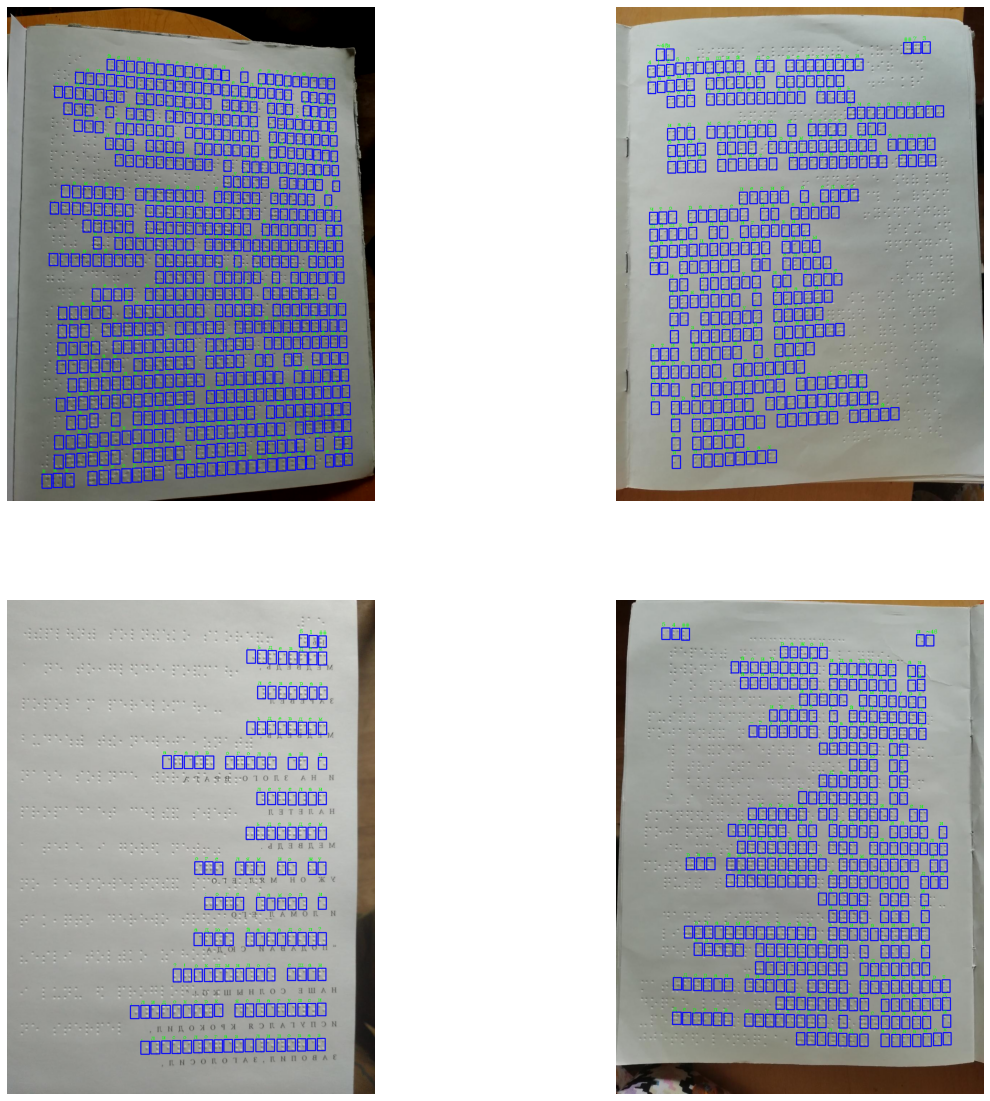

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1] - 5),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)


## 모델

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= True)

In [ ]:
num_classes = 84
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr= 0.005, weight_decay= 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= 0.1)

## 모델 학습을 위한 설정

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-aoij_5y8
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-aoij_5y8


In [ ]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [33]:
from engine import train_one_epoch, evaluate
import utils

## 학습

In [40]:
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

RuntimeError: ignored

In [32]:
torch.save(model.state_dict(), 'BrailleDetect.pt')